In [1]:
import sys
sys.path.append('./src/')

import numpy as np
import pandas as pd


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# https://python-graph-gallery.com/100-calling-a-color-with-seaborn/
model_colors = {'Naive': '#51DBE6',
                'SeasonalNaive': '#FA6F94',
                'Naive2': 'green',
                'RandomWalkDrift': 'maroon',
                'Croston': 'black',
                'MovingAverage': 'purple',
                'SeasonalMovingAverage': 'blue'}

def plot_single_serie(uid_df, title, ax, models, plt_h=60):
    """
    uid_df: pandas df
    panel with columns unique_id, ds, y, split
    y_hat_df: pandas df
    panel with columns unique_id, ds, y_hat
    """
    # parse uid_df
    uid_df.reset_index(inplace=True)
    
    # plot last 60 observations of actual date
    sns.lineplot(x='ds', y='y',
                 hue='split', data=uid_df[-plt_h:], ax=ax)
    
    # plot fitted models
    for model_name in models.keys():
        sns.lineplot(x='ds', y=model_name,
                     color=model_colors[model_name], data=uid_df[-plt_h:],
                     ax=ax, label=model_name)
    
    # rotate x axis
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y')
    ax.set_xlabel('Date Stamp')
    ax.set_ylabel('Value')
    ax.set_title(title)
    
    # remove legend title
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])

def plot_grid_series(y, uids, models):
    assert len(uids)==8
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 7))
    plt.subplots_adjust(wspace=0.35)
    plt.subplots_adjust(hspace=0.4)
    plt.xticks(rotation=45)

    for i, uid in enumerate(uids):
        # single plot parameters
        uid_df = y.loc[uid]
        row = int(np.round(i/8 + 0.001))
        col = i % 4
        
        plot_single_serie(uid_df, title=uid, ax=axs[row, col], models=models)
    
    fig.tight_layout()
    plt.show()
    plot_file = "./results/grid_series.png"
    plt.savefig(plot_file, bbox_inches = "tight", dpi=300)
    plt.close()


In [3]:
from src.benchmarks import *
from src.utils_data import m4_parser, seas_dict
from src.utils_evaluation import *

def button_models_metrics_filter(dataset_name, models_filter, metrics_filter):
    # Parse arguments
    h = seas_dict[dataset_name]['output_size']
    seasonality = seas_dict[dataset_name]['seasonality']
    
    models = {'Naive':  Naive(h=h),
              'SeasonalNaive': SeasonalNaive(h=h, seasonality=seasonality),
              'Naive2': Naive2(h=h, seasonality=seasonality),
              'RandomWalkDrift': RandomWalkDrift(h=h),
              'Croston': Croston(kind='classic'),
              'MovingAverage': MovingAverage(h=h, n_obs=20),
              'SeasonalMovingAverage': SeasonalMovingAverage(h=h, n_seasons=2,
                                                             seasonality=seasonality)}
    
    metrics = {'mse': mse, 'mape': mape, 'smape': smape, 
               'mase': mase, 'rmsse': rmsse}
    
    # Filtered models and metrics
    models = {model_name: models[model_name] for model_name in models_filter}
    metrics = {metric_name: metrics[metric_name] for metric_name in metrics_filter}
    
    return models, metrics

def button_uids_filter(y_df, size=8):
    uids = y_df.index.get_level_values('unique_id').unique()
    uids_sample = np.random.choice(uids, size=8)
    return uids_sample


In [4]:
def ml_pipeline(dataset_name, num_obs, models, metrics):
    # Parse arguments
    h = seas_dict[dataset_name]['output_size']
    seasonality = seas_dict[dataset_name]['seasonality']
    
    # Read data
    directory = './data/'
    X_train_df, y_train_df, X_test_df, y_test_df = m4_parser(dataset_name, directory, num_obs)

    # Pre sort dataframes for efficiency
    X_train_df = X_train_df.set_index(['unique_id', 'ds']).sort_index()
    y_train_df = y_train_df.set_index(['unique_id', 'ds']).sort_index()
    X_test_df = X_test_df.set_index(['unique_id', 'ds']).sort_index()
    y_test_df = y_test_df.set_index(['unique_id', 'ds']).sort_index()
    
    # Fit and predict benchmark models
    preds = [y_test_df.y]
    print("\n Fitting models")
    for model_name, model in models.items():
        print(model_name)
        
        panel_model = PanelModel(model)
        panel_model.fit(X_train_df, y_train_df)
        mod_preds = panel_model.predict(X_test_df)
        
        mod_preds.name = model_name
        preds.append(mod_preds)
    
    # Merge y_df for visualization purpose
    y_hat_df = pd.concat(preds, axis=1)
    y_train_df['split'] = 'train'
    y_hat_df['split'] = 'test'
    y_df = y_train_df.append(y_hat_df, sort=False)
    
    # Evaluation Metrics
    evaluations = {}
    print("\n Evaluating models")
    for metric_name, metric in metrics.items():
        print(metric_name)
        for mod_preds in preds[1:]:
            mod_evaluation = evaluate_panel(y_test=y_test_df, y_hat=mod_preds,
                                            y_train=y_train_df, metric=metric,
                                            seasonality=seasonality)
            mod_evaluation.name = mod_preds.name

            if not (metric_name in evaluations.keys()):
                evaluations[metric_name] = [mod_evaluation]
            else:
                evaluations[metric_name].append(mod_evaluation)
    
    # Collapse Metrics
    for metric_name, metric in metrics.items():
        evaluations[metric_name] = pd.concat(evaluations[metric_name], axis=1)
        evaluations[metric_name] = evaluations[metric_name].mean(axis=0)
    
    evaluations = pd.DataFrame.from_dict(evaluations)
    return y_df, evaluations



 Fitting models
RandomWalkDrift
Croston
MovingAverage
SeasonalMovingAverage

 Evaluating models
mape
smape
mase
rmsse


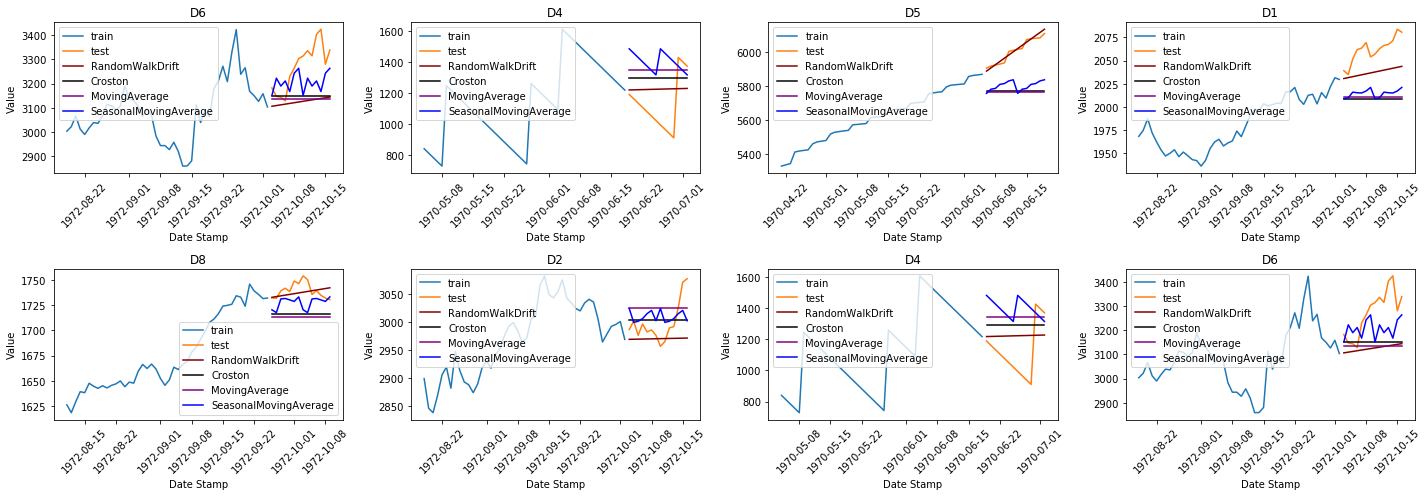

,mape,smape,mase,rmsse
RandomWalkDrift,7.268141,7.389714,156.181526,121.964740
Croston,8.680239,9.295579,205.620314,156.861786
MovingAverage,9.531116,10.132065,224.610488,169.538095
SeasonalMovingAverage,9.552721,9.987359,196.624595,152.233273


In [5]:
# Set random seeds
np.random.seed(1)

dataset_name = 'Daily'
num_obs = 8
#models_filter = ['Naive', 'SeasonalNaive', 'Naive2',
#                 'RandomWalkDrift', 'Croston', 'MovingAverage', 'SeasonalMovingAverage']
models_filter = ['RandomWalkDrift', 'Croston', 'MovingAverage', 'SeasonalMovingAverage']
metrics_filter = ['mape', 'smape', 'mase', 'rmsse']

models, metrics = button_models_metrics_filter(dataset_name, models_filter, metrics_filter)

# run ml_pipeline
y_df, metrics = ml_pipeline(dataset_name=dataset_name, num_obs=num_obs, 
                            models=models, metrics=metrics)

uids_sample = button_uids_filter(y_df, size=8)

plot_grid_series(y_df, uids_sample, models)
metrics

In [6]:
y_df

y  split  RandomWalkDrift      Croston  \
unique_id ds                                                         
D1        1970-01-01  1017.10  train              NaN          NaN   
          1970-01-02  1019.30  train              NaN          NaN   
          1970-01-03  1017.00  train              NaN          NaN   
          1970-01-04  1019.20  train              NaN          NaN   
          1970-01-05  1018.70  train              NaN          NaN   
...                       ...    ...              ...          ...   
D8        1972-10-05  1735.54   test      1739.301122  1715.924842   
          1972-10-06  1739.46   test      1740.027234  1715.924842   
          1972-10-07  1734.69   test      1740.753347  1715.924842   
          1972-10-08  1732.07   test      1741.479459  1715.924842   
          1972-10-09  1730.44   test      1742.205571  1715.924842   

                      MovingAverage  SeasonalMovingAverage  
unique_id ds                                                
D1        1970-01-01            NaN                    NaN  
          1970-01-02            NaN                    NaN  
          1970-01-03            NaN                    NaN  
          1970-01-04            NaN                    NaN  
          1970-01-05            NaN                    NaN  
...                             ...                    ...  
D8        1972-10-05       1713.648               1731.180  
          1972-10-06       1713.648               1731.615  
          1972-10-07       1713.648               1730.195  
          1972-10-08       1713.648               1728.715  
          1972-10-09       1713.648               1733.185  

[5590 rows x 6 columns]